In [1248]:
import torch
import pandas as pd
import torch.utils.data as data
from sklearn.preprocessing import MinMaxScaler
from typing import List
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassAccuracy
import smogn
from sklearn.cluster import KMeans
import numpy as np
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
from IPython.display import display
from scipy.stats import shapiro
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import abc

In [1249]:
train_data = pd.read_csv("../data/train_data.csv")
train_data

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,570796,2007,1928,24,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
4120,307079,2015,644,22,terraced,individual_heating,management_in_trust,102.0,400.0,0~5min,5min~10min,5.0,10.0,Daegu,7,7.0,11.0
4121,357522,2007,868,20,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
4122,312389,1978,1327,1,corridor,individual_heating,self_management,87.0,0.0,0~5min,0-5min,1.0,4.0,Kyungbuk_uni_hospital,3,7.0,11.0


#### Shapiro Test

In [1250]:
res = shapiro(train_data["Size(sqf)"])
res

ShapiroResult(statistic=0.9201284440300943, pvalue=2.836132240475931e-42)

#### Set up criteria for classifying the data

In [1251]:
CRITERIUM_MAX_AVERAGE = 350000
CRITERIUM_MAX_CHEAP = 100000

#### Discover & research of the dataset

In [1252]:
for column in train_data.columns:
    print(f"Number of unique rows in {column}: {train_data[column].nunique()}")

Number of unique rows in SalePrice: 841
Number of unique rows in YearBuilt: 16
Number of unique rows in Size(sqf): 89
Number of unique rows in Floor: 43
Number of unique rows in HallwayType: 3
Number of unique rows in HeatingType: 2
Number of unique rows in AptManageType: 2
Number of unique rows in N_Parkinglot(Ground): 23
Number of unique rows in N_Parkinglot(Basement): 20
Number of unique rows in TimeToBusStop: 3
Number of unique rows in TimeToSubway: 5
Number of unique rows in N_manager: 9
Number of unique rows in N_elevators: 13
Number of unique rows in SubwayStation: 8
Number of unique rows in N_FacilitiesInApt: 9
Number of unique rows in N_FacilitiesNearBy(Total): 11
Number of unique rows in N_SchoolNearBy(Total): 14


In [1253]:
COLUMNS_TO_DUMMY = [
    "HeatingType",
    "AptManageType",
    "HallwayType",
    "TimeToBusStop",
    "TimeToSubway",
    "SubwayStation",
]
OUTPUT_COLUMN = "SalePrice"

In [1254]:
def to_discrete(value):
    if value > CRITERIUM_MAX_AVERAGE:
        return 2
    elif value > CRITERIUM_MAX_CHEAP:
        return 1
    else:
        return 0

In [1255]:
discrete_column = train_data["SalePrice"].apply(to_discrete)
discrete_column.value_counts()

SalePrice
1    2992
2     570
0     562
Name: count, dtype: int64

In [1256]:
def classify(tensor) -> torch.tensor:
    return torch.where(
        tensor > CRITERIUM_MAX_AVERAGE,
        torch.tensor(2),
        torch.where(
            (tensor > CRITERIUM_MAX_CHEAP) & (tensor <= CRITERIUM_MAX_AVERAGE),
            torch.tensor(1),
            torch.tensor(0),
        ),
    )

In [1257]:
def count_unique_elements(tensor):
    unique_elements, counts = torch.unique(tensor, return_counts=True)
    for unique, count in zip(unique_elements, counts):
        print(f"Class {unique.item()}: {count.item()} occurrences")

# Create a dataset class

In [1258]:
class HouseDataset(data.Dataset):
    def __init__(self, path_to_csv: str, scaler=None) -> None:
        super().__init__()
        self.data = pd.read_csv(path_to_csv)
        self.scaler = scaler
        self._prepare_data()
        self.headers = list(self.data.columns)
        self._to_tensor()
        self.size = self.data.shape[0]

    def __len__(self) -> int:
        return self.size

    def __getitem__(self, idx) -> tuple[torch.tensor, torch.tensor]:
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

    def _to_dummy_columns(self, columns: List[str]) -> pd.DataFrame:
        dummy_columns = pd.get_dummies(self.data, columns=columns).astype(float)
        return dummy_columns

    def prepare_for_training(self) -> None:
        self.data = self.get_data_as_pandas()
        self._multiply_data()
        self.shuffle()
        self._to_tensor()

    def _scale_data(self) -> None:
        for column in self.data:
            if column not in COLUMNS_TO_DUMMY and column != OUTPUT_COLUMN:
                self.data[column] = self.scaler.fit_transform(
                    self.data[column].values.reshape(-1, 1)
                )

    def _prepare_data(self) -> None:
        self.data = self._to_dummy_columns(columns=COLUMNS_TO_DUMMY)
        if self.scaler:
            self._scale_data()

    def _to_tensor(self) -> None:
        self.headers = list(self.data.columns)
        self.label = torch.tensor(self.data.iloc[:, 0].values, dtype=torch.float32)
        self.data = torch.tensor(self.data.iloc[:, 1:].values, dtype=torch.float32)
        self.size = self.data.shape[0]

    def get_data_as_pandas(self) -> tuple[pd.DataFrame, pd.DataFrame]:
        data = pd.DataFrame(self.data.numpy())
        labels = pd.DataFrame(self.label.numpy())
        df = pd.concat([labels, data], axis=1)
        df.columns = self.headers
        return df

    @abc.abstractmethod
    def _multiply_data(self, number_of_duplicates: int = 1) -> None:
        return

    def shuffle(self):
        self.data.sample(frac=1)

# Create a dataset class for regression

In [1259]:
class HouseDatasetRegression(HouseDataset):
    def __init__(self, path_to_csv: str, scaler=None) -> None:
        super().__init__(path_to_csv, scaler)

    def _multiply_data(self, number_of_duplicates: int = 1) -> None:
        rows_to_duplicate_min = self.data[(self.data.iloc[:, 0] < CRITERIUM_MAX_CHEAP)]
        rows_to_duplicate_max = self.data[self.data.iloc[:, 0] > CRITERIUM_MAX_AVERAGE]
        self.data = pd.concat(
            [
                self.data,
                rows_to_duplicate_min.loc[
                    rows_to_duplicate_min.index.repeat(number_of_duplicates + 3)
                ],
                rows_to_duplicate_max.loc[
                    rows_to_duplicate_max.index.repeat(number_of_duplicates)
                ],
            ],
            ignore_index=True,
        )

    def _conduct_smogn(self) -> None:
        rg_mtrx = [
            [CRITERIUM_MAX_CHEAP, 1, 0],
            [CRITERIUM_MAX_AVERAGE, 0, 0],
            [500000, 1, 0],
        ]
        self.data = smogn.smoter(
            data=self.data,
            y=OUTPUT_COLUMN,
            rel_thres=0.98,
            samp_method="extreme",
            k=3,
            rel_method="manual",
            rel_ctrl_pts_rg=rg_mtrx,
        )

    def conduct_smote(self) -> None:
        smote = RandomOverSampler(shrinkage=0.5, random_state=42)
        x, y = smote.fit_resample(self.data, self.data[OUTPUT_COLUMN])
        self.data = pd.concat([y, x], axis=1)

    def cluster_kmeans(self, k: int = 3) -> None:
        model = KMeans(n_clusters=k)
        model = model.fit(self.data)
        labels = model.predict(self.data)
        return labels

# Create a dataset class for classification

In [1260]:
class HouseDatasetClassification(HouseDataset):
    def __init__(self, path_to_csv: str, scaler=None) -> None:
        super().__init__(path_to_csv, scaler)
        self._classify_data()

    def _classify_data(self) -> None:
        self.label = torch.where(
            self.label > CRITERIUM_MAX_AVERAGE,
            torch.tensor(2),
            torch.where(
                (self.label > CRITERIUM_MAX_CHEAP)
                & (self.label <= CRITERIUM_MAX_AVERAGE),
                torch.tensor(1),
                torch.tensor(0),
            ),
        )

    def _multiply_data(self, number_of_duplicates: int = 1) -> None:
        ros = RandomOverSampler()
        x, y = ros.fit_resample(self.data.iloc[:,1:], self.data[OUTPUT_COLUMN])
        self.data = pd.concat([y, x], axis=1)

In [1261]:
path = "../data/train_data.csv"
scaler = MinMaxScaler()
train_dataset = HouseDatasetRegression(path, scaler)

In [1262]:
train_dataset_classify = HouseDatasetClassification(path, scaler)
train_dataset_classify.prepare_for_training()
train_dataset_classify_df = train_dataset_classify.get_data_as_pandas()

In [1263]:
train_dataset_classify_df
train_dataset_classify_df.dtypes

SalePrice                              float32
YearBuilt                              float32
Size(sqf)                              float32
Floor                                  float32
N_Parkinglot(Ground)                   float32
N_Parkinglot(Basement)                 float32
N_manager                              float32
N_elevators                            float32
N_FacilitiesInApt                      float32
N_FacilitiesNearBy(Total)              float32
N_SchoolNearBy(Total)                  float32
HeatingType_central_heating            float32
HeatingType_individual_heating         float32
AptManageType_management_in_trust      float32
AptManageType_self_management          float32
HallwayType_corridor                   float32
HallwayType_mixed                      float32
HallwayType_terraced                   float32
TimeToBusStop_0~5min                   float32
TimeToBusStop_10min~15min              float32
TimeToBusStop_5min~10min               float32
TimeToSubway_

In [1264]:
train_dataset.prepare_for_training()
train_data_df = train_dataset.get_data_as_pandas()
# sns.heatmap(train_data.corr())

<Axes: >

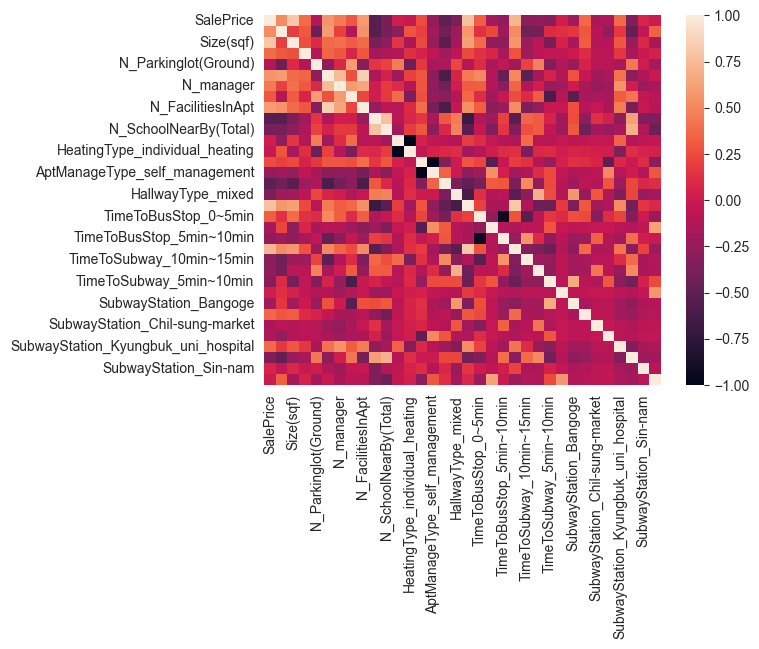

In [1265]:
train_data_df
sns.heatmap(train_data_df.corr())

In [1266]:
train_data_df.iloc[:, 0].apply(to_discrete).value_counts()

SalePrice
1    2992
0    2786
2    1140
Name: count, dtype: int64

In [1267]:
train_dataset_classify_df.iloc[:, 0].value_counts()

SalePrice
1.0    2992
0.0    2992
2.0    2992
Name: count, dtype: int64

In [1268]:
train_data_df

,SalePrice,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,N_FacilitiesInApt,N_FacilitiesNearBy(Total),...,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,141592.0,0.756757,0.308356,0.047619,0.155680,0.139288,0.153846,0.000000,0.444444,0.3750,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,51327.0,0.189189,0.205268,0.166667,0.112202,0.057532,0.076923,0.074074,0.222222,0.7500,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,48672.0,0.189189,0.205268,0.119048,0.112202,0.057532,0.076923,0.074074,0.222222,0.7500,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,380530.0,0.756757,0.872389,0.166667,0.349229,0.405753,0.307692,0.407407,0.444444,0.1875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,78318.0,0.378378,0.231154,0.023810,0.199158,0.059803,0.230769,0.296296,0.222222,0.5625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6913,491150.0,0.783784,0.628520,0.476190,0.000000,0.961393,1.000000,0.592593,1.000000,0.5625,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6914,557522.0,0.783784,0.814260,0.452381,0.000000,0.961393,1.000000,0.592593,1.000000,0.5625,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6915,570796.0,0.783784,0.814260,0.547619,0.000000,0.961393,1.000000,0.592593,1.000000,0.5625,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6916,357522.0,0.783784,0.332879,0.452381,0.000000,0.961393,1.000000,0.592593,1.000000,0.5625,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [1269]:
labels = classify(train_dataset.label)
count_unique_elements(labels)

Class 0: 2786 occurrences
Class 1: 2992 occurrences
Class 2: 1140 occurrences


In [1270]:
train_dataset.size

6918

#### Split the data into training and validation sets

In [1271]:
X_train, X_test, y_train, y_test = train_test_split(
    train_dataset.data, train_dataset.label, test_size=0.33, random_state=42
)
train_data = data.TensorDataset(X_train, y_train)
validation_data = data.TensorDataset(X_test, y_test)

#### Create the data loaders

In [1272]:
batch_size = 32
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [1273]:
class HousingRegressionModel(nn.Module):
    def __init__(self, input_size: int, output_size: int) -> None:
        super().__init__()
        self.fc1 = nn.Linear(input_size, 56)
        self.dropout = nn.Dropout(0.1)
        self.gelu = nn.LeakyReLU()
        self.fc2 = nn.Linear(56, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x: torch.tensor) -> torch.tensor:
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.gelu(x)
        x = self.fc2(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [1274]:
model = HousingRegressionModel(input_size=train_dataset.data.shape[1], output_size=1)

In [1275]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.006)

In [1276]:
loss_fn = nn.MSELoss()

In [1277]:
mca = MulticlassAccuracy(num_classes=3, average=None)

In [1278]:
EPOCHS_NUMBER = 1600
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
tqdm_progress = tqdm(range(EPOCHS_NUMBER))
for epoch in tqdm_progress:
    train_batch_loss_sum, val_batch_loss_sum = 0, 0
    train_batch_accuracy_sum, val_batch_accuracy_sum = 0, 0
    model.train()
    batch_idx = 0
    for data, label in train_loader:
        model_output = model(data).squeeze()
        loss = loss_fn(model_output, label)
        loss.backward()
        optimizer.step()
        train_batch_loss_sum += loss.item()
        optimizer.zero_grad()
        batch_idx += 1
        train_predicts_classify = classify(model_output)
        train_data_classify = classify(label)
        train_batch_accuracy_sum += mca(train_predicts_classify, train_data_classify)
    train_batch_accuracy_avg = train_batch_accuracy_sum / batch_idx
    mean_error_train = train_batch_loss_sum / len(train_loader)
    train_losses.append(mean_error_train)
    train_accuracies.append(train_batch_accuracy_avg)
    model.eval()
    batch_val_idx = 0
    for val_inputs, val_labels in validation_loader:
        val_predicts = model(val_inputs).squeeze(dim=1)
        val_loss = loss_fn(val_predicts, val_labels)
        val_batch_loss_sum += val_loss.item()
        val_batch_loss = val_batch_loss_sum / (len(validation_loader.dataset))
        val_losses.append(val_batch_loss)
        batch_val_idx += 1
        val_predicts_classify = classify(val_predicts)
        val_data_classify = classify(val_labels)
        val_batch_accuracy_sum += mca(val_predicts_classify, val_data_classify)
    val_batch_accuracy_avg = val_batch_accuracy_sum / batch_val_idx
    mean_error_val = val_batch_loss_sum / len(train_loader)
    tqdm_progress.set_postfix(
        {
            "Epoch": epoch + 1,
            "Loss in train": {mean_error_train},
            "Loss in eval": {mean_error_val},
        }
    )
    val_accuracies.append(val_batch_accuracy_avg)
    val_losses.append(mean_error_val)

100%|██████████| 1600/1600 [06:13<00:00,  4.28it/s, Epoch=1600, Loss in train={1812518973.0506911}, Loss in eval={1483433912.0368664}]


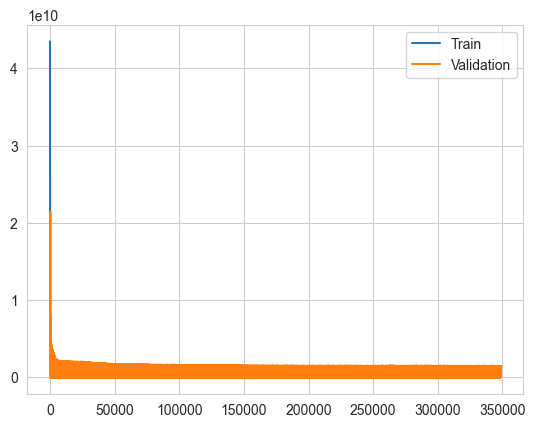

In [1279]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.legend()

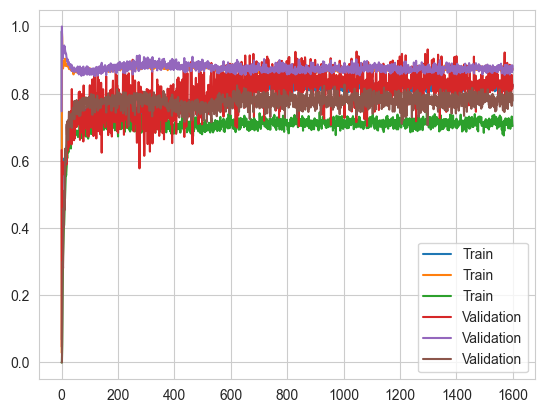

In [1280]:
plt.plot(train_accuracies, label="Train")
plt.plot(val_accuracies, label="Validation")
plt.legend()

In [1281]:
train_accuracies_mean = [tensor.mean().item() for tensor in train_accuracies]
val_accuracies_mean = [tensor.mean().item() for tensor in val_accuracies]

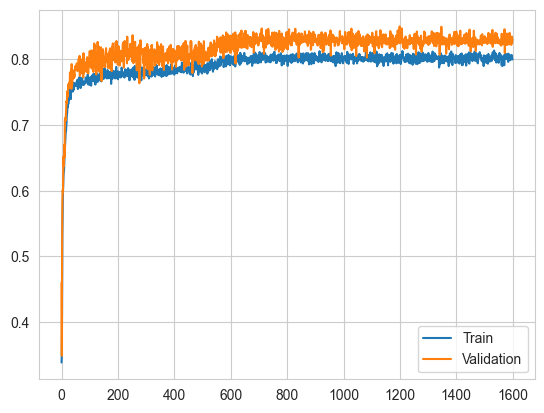

In [1282]:
plt.plot(train_accuracies_mean, label="Train")
plt.plot(val_accuracies_mean, label="Validation")
plt.legend()

In [1283]:
val_accuracies

[tensor([0.6322, 0.7476, 0.0000]),
 tensor([0.0459, 1.0000, 0.0000]),
 tensor([0.4916, 0.9404, 0.0896]),
 tensor([0.5712, 0.9205, 0.2579]),
 tensor([0.5955, 0.9046, 0.3012]),
 tensor([0.5973, 0.9154, 0.2805]),
 tensor([0.5856, 0.9199, 0.3816]),
 tensor([0.5753, 0.9215, 0.4599]),
 tensor([0.5704, 0.9378, 0.4036]),
 tensor([0.5599, 0.9434, 0.4608]),
 tensor([0.5648, 0.9342, 0.5119]),
 tensor([0.5587, 0.9395, 0.4542]),
 tensor([0.5578, 0.9304, 0.6361]),
 tensor([0.5734, 0.9256, 0.6328]),
 tensor([0.6068, 0.9187, 0.5935]),
 tensor([0.5917, 0.9195, 0.6223]),
 tensor([0.6222, 0.9178, 0.6182]),
 tensor([0.5893, 0.9092, 0.6988]),
 tensor([0.5945, 0.9064, 0.7096]),
 tensor([0.6199, 0.9034, 0.6775]),
 tensor([0.6416, 0.8949, 0.7164]),
 tensor([0.6308, 0.9024, 0.6952]),
 tensor([0.6413, 0.8948, 0.7203]),
 tensor([0.7093, 0.8898, 0.6625]),
 tensor([0.7107, 0.8858, 0.6898]),
 tensor([0.6575, 0.8947, 0.7148]),
 tensor([0.6416, 0.8875, 0.7463]),
 tensor([0.7060, 0.8852, 0.7017]),
 tensor([0.6989, 0.8

In [1284]:
# model = HousingRegressionModel(input_size=train_dataset.data.shape[1], output_size=1)
# model.load_state_dict(torch.load("../models/housing_model_3_85_6.pth"))

In [1285]:
with torch.no_grad():
    predicts_train = model(X_train.clone().detach())
    predicts_val = model(X_test.clone().detach())
    predicts_classified_train = classify(predicts_train)
    predicts_classified_val = classify(predicts_val)
    y_train_classified = classify(y_train)
    y_test_classified = classify(y_test)

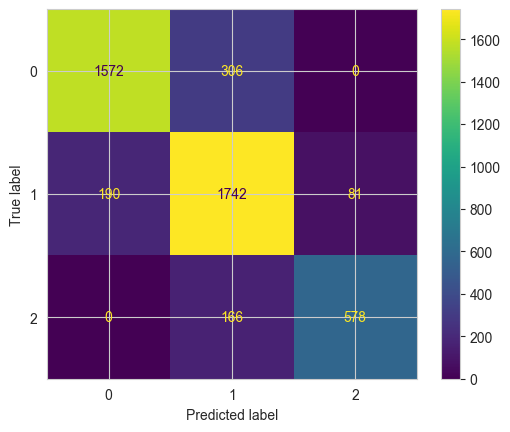

In [1286]:
conf_matrix = confusion_matrix(y_train_classified, predicts_classified_train)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()

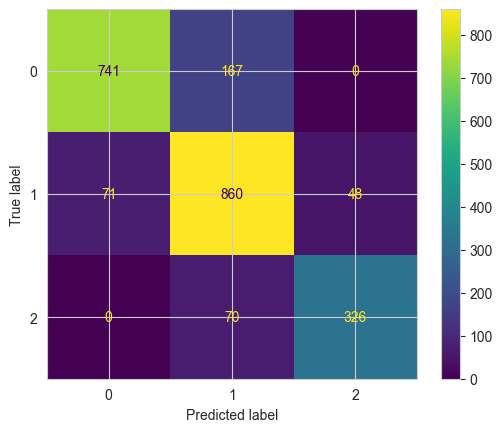

In [1287]:
conf_matrix_val = confusion_matrix(y_test_classified, predicts_classified_val)
ConfusionMatrixDisplay(conf_matrix_val).plot()
plt.show()

In [1288]:
f1_score(y_test_classified, predicts_classified_val, average="micro")

0.8440648269820412

In [1289]:
# torch.save(model.state_dict(), "../models/housing_model_2.pth")
# 64 last

In [1290]:
# torch.save(model.state_dict(), "../models/housing_model_3_83_7.pth")
# 32 last

In [1291]:
# torch.save(model.state_dict(), "../models/housing_model_3_84.pth")

In [1292]:
# torch.save(model.state_dict(), "../models/housing_model_3_85_6.pth")

In [1293]:
# torch.save(model.state_dict(), "../models/housing_model_the_best.pth")

# Classification model

In [1294]:
class HousingClassificationModel(nn.Module):
    def __init__(self, input_size: int, class_num: int) -> None:
        super().__init__()
        self.fc1 = nn.Linear(input_size, 156)
        self.dropout = nn.Dropout(0.1)
        self.gelu = nn.LeakyReLU()
        self.fc2 = nn.Linear(156, 120)
        self.fc3 = nn.Linear(120,  class_num)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.tensor) -> torch.tensor:
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.gelu(x)
        x = self.fc2(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [1295]:
train_dataset_classify = HouseDatasetClassification(path, scaler)
train_dataset_classify.prepare_for_training()
train_dataset_classify_df = train_dataset_classify.get_data_as_pandas()

In [1296]:
import torch.utils.data as data

In [1297]:
batch_size = 32
train_loader_classify = data.DataLoader(train_dataset_classify, batch_size=batch_size, shuffle=True)
validation_loader_classify = data.DataLoader(train_dataset_classify, batch_size=batch_size, shuffle=True)

In [1298]:
X_train_classify, X_test_classify, y_train_classify, y_test_classify = train_test_split(
    train_dataset_classify.data, train_dataset_classify.label, test_size=0.33, random_state=42
)
train_data_classify = data.TensorDataset(X_train_classify, y_train_classify)
validation_data_classify = data.TensorDataset(X_test_classify, y_test_classify)

In [1299]:
model_classify = HousingClassificationModel(input_size=train_dataset_classify.data.shape[1], class_num=3)

In [1300]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.06)

In [1301]:
loss_fn_classify = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 0.3, 1]))

In [1302]:
mca = MulticlassAccuracy(num_classes=3, average=None)

In [1303]:
EPOCHS_NUMBER = 1600
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
tqdm_progress = tqdm(range(EPOCHS_NUMBER))
for epoch in tqdm_progress:
    train_batch_loss_sum, val_batch_loss_sum = 0, 0
    train_batch_accuracy_sum, val_batch_accuracy_sum = 0, 0
    model_classify.train()
    batch_idx = 0
    for data, label in train_loader_classify:
        model_output = model_classify(data).squeeze()
        loss = loss_fn_classify(model_output, label.type(torch.LongTensor))
        loss.backward()
        optimizer.step()
        train_batch_loss_sum += loss.item()
        optimizer.zero_grad()
        batch_idx +=1
    mean_error_train = train_batch_loss_sum / len(train_loader)
    train_losses.append(mean_error_train)
    train_batch_accuracy_sum += mca(model_output, label)
    train_batch_accuracy_avg = train_batch_accuracy_sum / batch_idx
    train_accuracies.append(train_batch_accuracy_avg)
    model_classify.eval()
    batch_val_idx = 0
    for val_inputs, val_labels in validation_loader_classify:
        val_predicts = model_classify(val_inputs).squeeze(dim=1)
        val_loss = loss_fn_classify(val_predicts, val_labels.type(torch.LongTensor))
        val_batch_loss_sum += val_loss.item()
        train_batch_loss = train_batch_loss_sum / (len(train_loader.dataset))
        val_batch_loss = val_batch_loss_sum / (len(validation_loader.dataset))
        val_losses.append(val_batch_loss)
        batch_val_idx = 0
    mean_error_val = val_batch_loss_sum / len(train_loader)
    val_batch_accuracy_sum += mca(val_predicts, val_labels)
    val_batch_accuracy_avg = val_batch_accuracy_sum / batch_idx
    tqdm_progress.set_postfix(
        {
            "Epoch": epoch + 1,
            "Los in train": {mean_error_train},
            "Loss in eval": {mean_error_val},
        }
    )
    val_accuracies.append(val_batch_accuracy_avg)
    val_losses.append(mean_error_val)

100%|██████████| 1600/1600 [06:13<00:00,  4.28it/s, Epoch=1600, Los in train={1.433490056596044}, Loss in eval={1.4323007395739928}] 


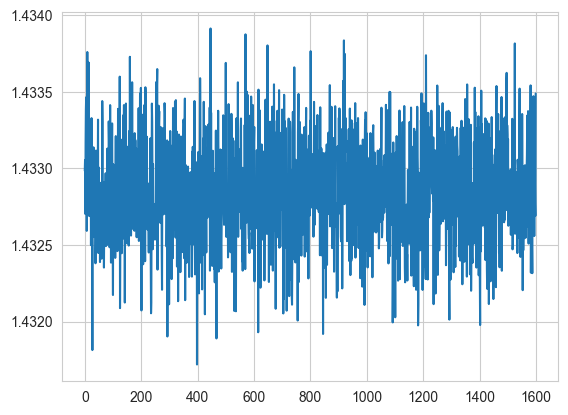

In [1304]:
plt.plot(train_losses, label="Train")

In [1305]:
with torch.no_grad():
    predicts_train = model_classify(X_train.clone().detach())
    predicts_val = model_classify(X_test.clone().detach())
    predicted_argmax_train = torch.argmax(predicts_train, dim=1)
    predicted_argmax_val = torch.argmax(predicts_val, dim=1)

In [1306]:
predicts_train

tensor([[-0.1404, -0.0340, -0.0960],
        [-0.1046, -0.0120, -0.0058],
        [-0.1335, -0.0236, -0.0316],
        ...,
        [-0.1341, -0.0231, -0.0316],
        [-0.1687,  0.0016, -0.0655],
        [-0.1354, -0.0216, -0.0317]])

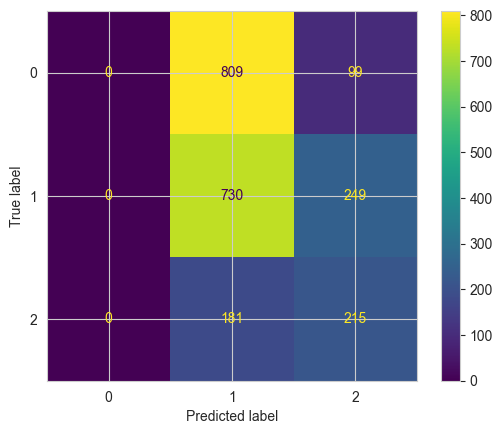

In [1307]:
conf_matrix_val = confusion_matrix(y_test_classified, predicted_argmax_val)
ConfusionMatrixDisplay(conf_matrix_val).plot()
plt.show()

In [1308]:
f1_score(y_test_classified, predicted_argmax_val, average="micro")

0.41392904073587383

In [1309]:
train_accuracies_mean = [tensor.mean().item() for tensor in train_accuracies]
val_accuracies_mean = [tensor.mean().item() for tensor in val_accuracies]

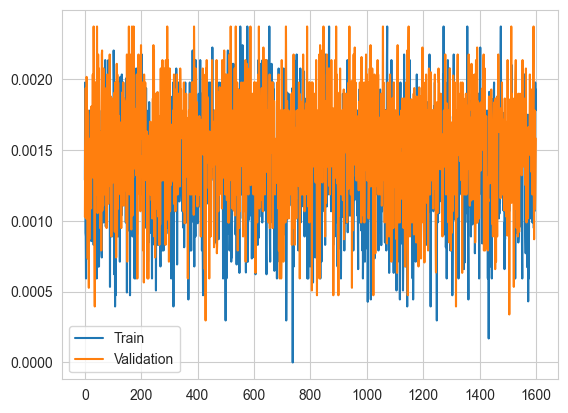

In [1310]:
plt.plot(train_accuracies_mean, label="Train")
plt.plot(val_accuracies_mean, label="Validation")
plt.legend()